## Amazon Reviews Classification
Classify Real(OR) and Computer generated(CG) reviews

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd

In [55]:
df = pd.read_csv("../../data/classification/data/data.csv")

### Analyse Dataset

In [57]:
df["n_words"] = df["text_"].apply(lambda x: len(x.split(" ")))

/home/lazylearner/anaconda3/envs/amazonreviews/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of Reviews')

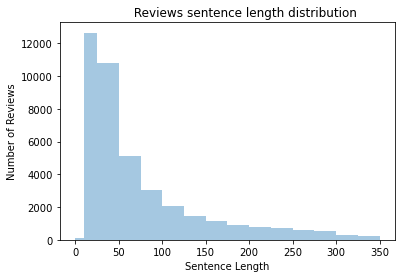

In [58]:
sns.distplot(a=df["n_words"], kde=False, bins=[0,10,25,50,75,100,125,150,175,200,225,250,275,300,325,350])
plt.title("         Reviews sentence length distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Reviews")

Text(0.5, 1.0, '        Review counts by target column')

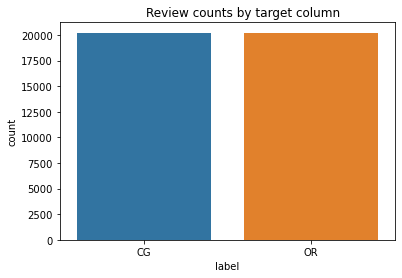

In [59]:
sns.countplot(data=df, x="label")
plt.title("        Review counts by target column")
# plt.yticks(rotation=45)

Text(0.5, 1.0, '        Review counts by categories')

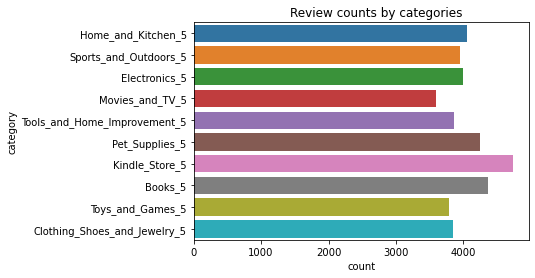

In [60]:
sns.countplot(data=df, y="category")
plt.title("        Review counts by categories")

### Detection

#### Baseline-1
After doing a literature survey of identifying real v/s generated text, we figured out that OpenAi has already worked upon similar problem of identifying gpt-2 output dataset from real world texts.
Their best performing model was a finetuned roberta on webtext data. As a very first baseline we tried using their pretrained model on our validation dataset.    
[Source](https://d4mucfpksywv.cloudfront.net/papers/GPT_2_Report.pdf)
##### Classification Report
                precision    recall  f1-score   support

          CG       0.76      0.92      0.84      4010
          OR       0.90      0.72      0.80      4077

    accuracy                           0.82      8087
    macro avg      0.83      0.82      0.82      8087
    weighted avg   0.83      0.82      0.82      8087


#### Baseline-2
We wanted to try out a very simple baseline to compare results. Tried out Naive Bayes with Logitic Regression as another baseline.   
[Source](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)

###### Classification Report
                precision    recall  f1-score   support

          CG       0.96      0.93      0.95      4010
          OR       0.94      0.96      0.95      4077

    accuracy                           0.95      8087
    macro avg      0.95      0.95      0.95      8087
    weighted avg   0.95      0.95      0.95      8087


#### Final Model
Inspired from the very same idea by OpenAi of finetuning RoBERTa, we decided to finetune RoBERTa on our dataset consisting of real reviews from Amazon dataset against our Generated reviews from Finetuned GPT-2 in the phase-1 of the project.
Idea being RoBERTa is a masked and non-generative language model that does not share the same architecture or the same tokenizer as GPT-2.   

The RoBERTa model was proposed in [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018.
It builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.
[Source](https://huggingface.co/transformers/model_doc/roberta.html)

##### Classification Report
                precision    recall  f1-score   support

          CG       0.97      0.96      0.97      4010
          OR       0.97      0.97      0.97      4077

    accuracy                           0.97      8087
    macro avg      0.97      0.97      0.97      8087
    weighted avg   0.97      0.97      0.97      8087


### Analyse models predictions

Post analysis of our above three models against different categories of Amazon Reviews is added below:

In [3]:
encoded_label_dict = {"CG" : 0, "OR" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [4]:
df["target"] = df["label"].apply(lambda x: encode_label(x))

In [5]:
train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=2021)

In [6]:
df1 = pd.read_csv("../../data/classification/data/gpt2_detector_predictions.csv")
df2 = pd.read_csv("../../data/classification/data/ft_roberta_predictions.csv")
df3 = pd.read_csv("../../data/classification/data/NbLogReg_predictions.csv")

In [7]:
merged_df = pd.concat([valid_df.reset_index(drop=True), df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True)], axis= 1)

In [8]:
merged_df.head()

,category,rating,label,text_,target,GPT2_Detector_Model_Probability,GPT2_Detector_Model_Prediction,Finetune_Roberta_Model_Probability,Finetune_Roberta_Model_Prediction,NbLogReg_Model_Probability,NbLogReg_Model_Prediction
0,Electronics_5,4.0,CG,I bought this cover for my wife and she loves ...,0,0.005580,0,0.032347,0,0.000938,0
1,Pet_Supplies_5,5.0,CG,I have been giving this to my dog for about a ...,0,0.000172,0,0.013948,0,0.002291,0
2,Tools_and_Home_Improvement_5,4.0,OR,"All as described, and should be for what it is...",1,0.321705,0,0.902460,1,0.921376,1
3,Books_5,5.0,OR,"This isn't a just a zombie SAW-like story, but...",1,0.002924,0,0.999647,1,0.992723,1
4,Books_5,3.0,OR,This historical thriller revolves around the E...,1,0.999816,1,0.999547,1,0.990737,1


In [9]:
# merged_df.to_csv("../../data/classification/data/MergedPredictions.csv",index=None)

In [2]:
merged_df = pd.read_csv("../../data/classification/data/MergedPredictions.csv")

In [3]:
merged_df["gpt2_matched"] = merged_df["target"] == merged_df["GPT2_Detector_Model_Prediction"]
merged_df["roberta_matched"] = merged_df["target"] == merged_df["Finetune_Roberta_Model_Prediction"]
merged_df["nb_matched"] = merged_df["target"] == merged_df["NbLogReg_Model_Prediction"]

In [4]:
gpt2_category_acc = merged_df.groupby("category")["gpt2_matched"].mean()*100

In [15]:
print(f"Accuracies across different categories for openAI GPT-2 output detector")
pd.DataFrame({"Category" : gpt2_category_acc.index, "Accuracy" : gpt2_category_acc.values})

Accuracies across different categories for openAI GPT-2 output detector


,Category,Accuracy
0,Books_5,84.282460
1,Clothing_Shoes_and_Jewelry_5,78.913325
2,Electronics_5,82.772021
3,Home_and_Kitchen_5,82.070707
4,Kindle_Store_5,86.383442
5,Movies_and_TV_5,83.356259
6,Pet_Supplies_5,81.516588
7,Sports_and_Outdoors_5,80.048077
8,Tools_and_Home_Improvement_5,80.175659
9,Toys_and_Games_5,79.973475


In [5]:
roberta_category_acc = merged_df.groupby("category")["roberta_matched"].mean()*100

In [14]:
print(f"Accuracies across different categories for RoBERTa classifier Finetuned on IMDB real and generated reviews")
pd.DataFrame({"Category" : roberta_category_acc.index, "Accuracy" : roberta_category_acc.values})

Accuracies across different categories for RoBERTa classifier Finetuned on IMDB real and generated reviews


,Category,Accuracy
0,Books_5,97.038724
1,Clothing_Shoes_and_Jewelry_5,95.989651
2,Electronics_5,98.445596
3,Home_and_Kitchen_5,96.085859
4,Kindle_Store_5,96.296296
5,Movies_and_TV_5,96.561210
6,Pet_Supplies_5,96.563981
7,Sports_and_Outdoors_5,97.475962
8,Tools_and_Home_Improvement_5,96.235885
9,Toys_and_Games_5,94.960212


In [6]:
nb_category_acc = merged_df.groupby("category")["nb_matched"].mean()*100

In [16]:
print(f"Accuracies across different categories for NBLogisticRegression trained on IMDB real and generated reviews")
pd.DataFrame({"Category" : nb_category_acc.index, "Accuracy" : nb_category_acc.values})

Accuracies across different categories for NBLogisticRegression trained on IMDB real and generated reviews


,Category,Accuracy
0,Books_5,94.077449
1,Clothing_Shoes_and_Jewelry_5,94.954722
2,Electronics_5,95.595855
3,Home_and_Kitchen_5,96.464646
4,Kindle_Store_5,94.444444
5,Movies_and_TV_5,93.397524
6,Pet_Supplies_5,93.720379
7,Sports_and_Outdoors_5,95.913462
8,Tools_and_Home_Improvement_5,95.106650
9,Toys_and_Games_5,93.766578


Text(0.5, 1.0, 'Accuracies across categories for NBLogisticRegression')

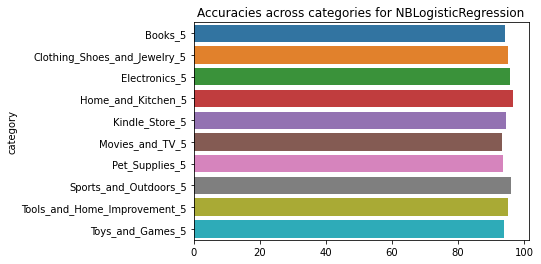

In [9]:
sns.barplot(x=nb_category_acc.values,y=nb_category_acc.index)
plt.title("Accuracies across categories for NBLogisticRegression")

Text(0.5, 1.0, 'Accuracies across categories for GPT2-OutputDetector')

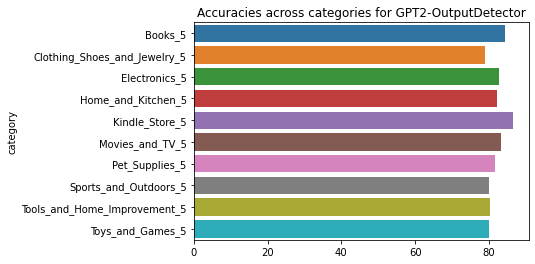

In [15]:
sns.barplot(x=gpt2_category_acc.values,y=gpt2_category_acc.index)
plt.title("Accuracies across categories for GPT2-OutputDetector")
# plt.yticks(rotation=45)

Text(0.5, 1.0, 'Accuracies across categories for Finetuned Roberta')

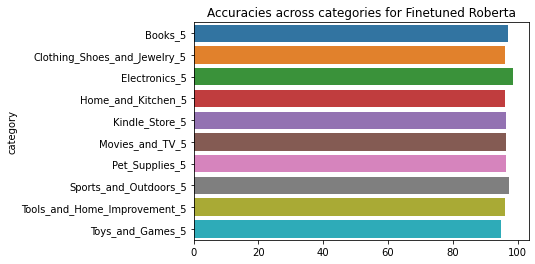

In [16]:
sns.barplot(x=roberta_category_acc.values,y=roberta_category_acc.index)
plt.title("Accuracies across categories for Finetuned Roberta")
# plt.yticks(rotation=45)

In [20]:
merged_df["n_words"] = merged_df["text_"].apply(lambda x: len(x.split(" ")))

Text(0.5, 0, 'Number of words in reviews')

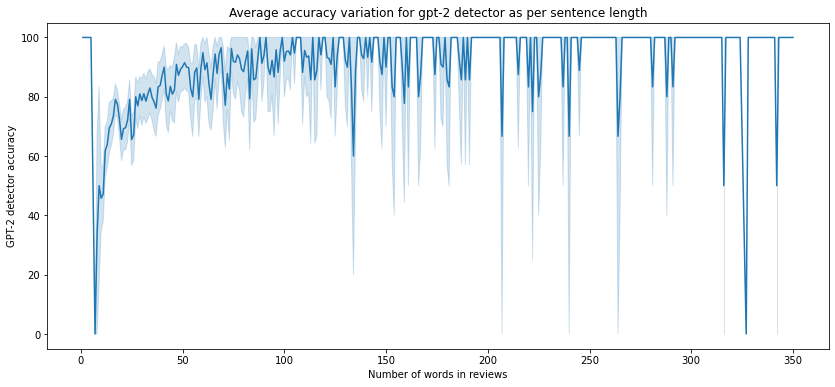

In [51]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy variation for gpt-2 detector as per sentence length")
sns.lineplot(x=merged_df["n_words"],y=merged_df["gpt2_matched"]*100)
plt.ylabel("GPT-2 detector accuracy")
plt.xlabel("Number of words in reviews")

Text(0.5, 0, 'Number of words in reviews')

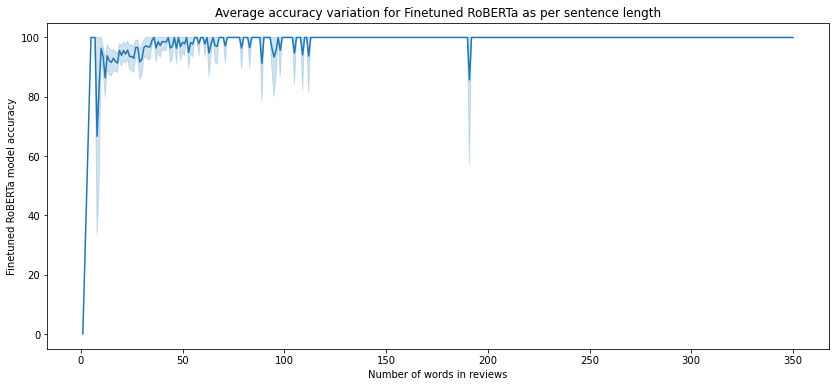

In [52]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy variation for Finetuned RoBERTa as per sentence length")
sns.lineplot(x=merged_df["n_words"],y=merged_df["roberta_matched"]*100)
plt.ylabel("Finetuned RoBERTa model accuracy")
plt.xlabel("Number of words in reviews")

Text(0.5, 0, 'Number of words in reviews')

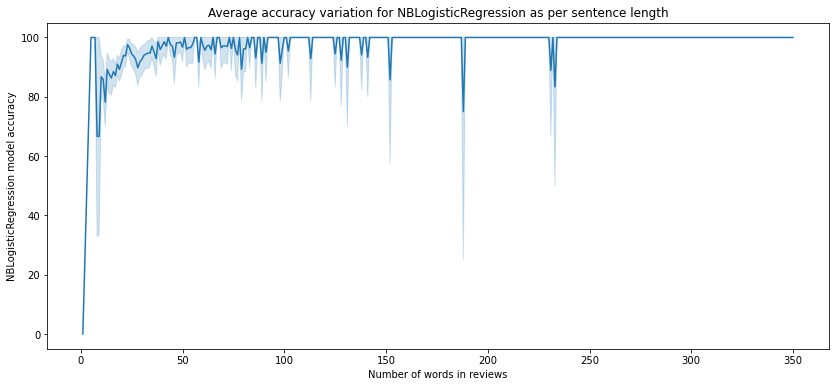

In [53]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy variation for NBLogisticRegression as per sentence length")
sns.lineplot(x=merged_df["n_words"],y=merged_df["nb_matched"]*100)
plt.ylabel("NBLogisticRegression model accuracy")
plt.xlabel("Number of words in reviews")

Text(0, 0.5, 'GPT-2 detector accuracy')

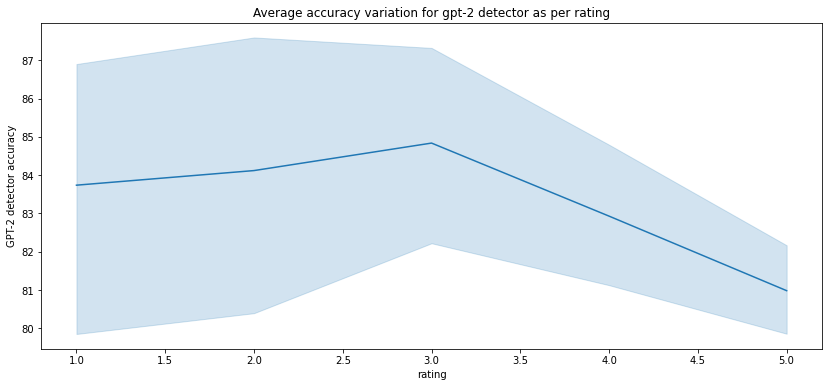

In [48]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy variation for gpt-2 detector as per rating")
sns.lineplot(x=merged_df["rating"],y=merged_df["gpt2_matched"]*100)
plt.ylabel("GPT-2 detector accuracy")

Text(0, 0.5, 'Finetuned RoBERTa model accuracy')

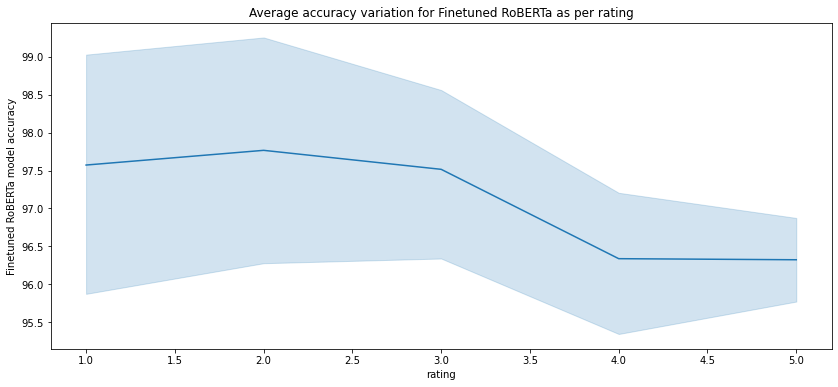

In [47]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy variation for Finetuned RoBERTa as per rating")
sns.lineplot(x=merged_df["rating"],y=merged_df["roberta_matched"]*100)
plt.ylabel("Finetuned RoBERTa model accuracy")

Text(0, 0.5, 'NBLogisticRegression model accuracy')

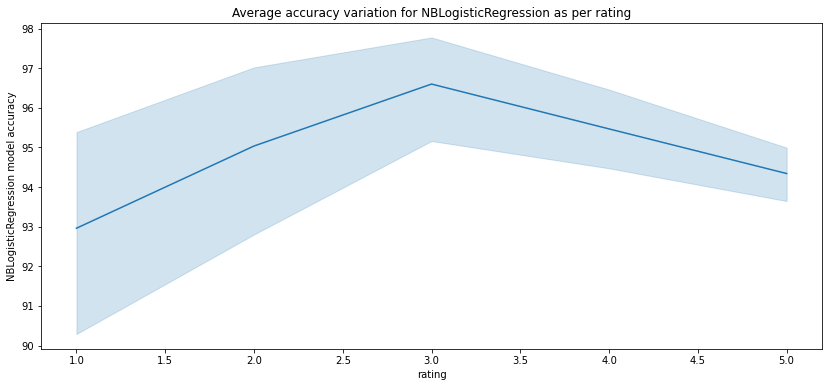

In [46]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy variation for NBLogisticRegression as per rating")
sns.lineplot(x=merged_df["rating"],y=merged_df["nb_matched"]*100)
plt.ylabel("NBLogisticRegression model accuracy")

### Observations

##### Did we beat the baseline? By how much?    
Comparing our final model which is a FineTuned RoBERTa on our dataset(i.e. mix of generated and real reviews) with our first baseline openAI's gpt-2 output detector, we did manage to surpass the former baseline performance by nearly 14% in accuracy. Pretrained openAI gpt-2 output detector's accuracy on the validation set was coming out to be ~83% while our final model gave an accuracy of ~97% on the validation set.   
Comparing our final model with another simpler but stonger baseline which a variant of NB(Naive Bayes) with Logistic Regression oftenly used as baseline for text classification, here also we were able to improve accuracy by ~2%. NB Logistic Regression model trained on our dataset was performing with ~95% accuracy on the validation set while our final model as stated above was performing at an accuracy of ~97% on the same validation set.   
##### Is the difference statistically significant? (McMemar's test)   
TBD  
##### Were there notable differences by category, rating or length, or did the detection work equally well across all of them? 
Comparing model performances across different categoris of reviews, we can see that all the three models perform relatively the same on all top-10 categories in comparison to their overall accuracies. One thing we can notice is with gpt-2 output detector model we can see a delta of +- 10% for few of the categories while this same delta lowers down to ~3% when it comes to NBLogistic model or our final finetuned RoBERTa model. Our Finetuned RoBERTa model gives gt95% acccuracies across all categories while NBLogistic Regression model keeps an accuracy of gt93% across all categories of reviews.  

Comparing model performances across different lengths of sentences we can definitely observe that models are much more accurate and consistent for longer sentences in comparison to shorter sentences.  
##### What are the implications for practice - meaning, can we trust this model and what are its limitations? 
Yes, it's a step towards researching and exploring text generation capabilities in NLP. Also, adding classification strategies for the same to be able to identify generated text from real and keep it clean, safe to be used for good.   
All the datasets, model parameters, model weights and initialisation seeds have been kept for experimentation reproducibilty.  
Would love to see more researches in the same direction.
##### How would we develop it further (meaning both the generator and the classifier) if we had more time?   
Given more time and ideas to develop it further, we can definitely try improving our ULMFit approach to finetune LM on amazon reviews.  
Another thing we can try is benchmarking classification performances for different set of sampling techniques used  in text generation. Right now, we focused primarily on top-k nucleus sampling to generate our generated reviews dataset but, different sampling techniaues can be applied and classification performances can be analysed for different datasets generated from different sampling techniques.